In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy as sp
from plot_lib import *

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

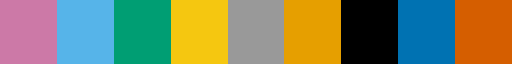

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_mcf7 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_MCF7.tsv", sep="\t")

In [7]:
mcf7 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_MCF7_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

mcf7 = mcf7.loc[mcf7.is_M2Kb & (mcf7.is_pls | mcf7.is_pels | mcf7.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
mcf7 = mcf7.loc[mcf7.tf.isin(collectri.source) & mcf7.tf.isin(chip_atlas_mcf7.tf)]
mcf7.shape

(543778, 2)

In [8]:
chip_atlas_mcf7 = chip_atlas_mcf7.loc[chip_atlas_mcf7.tf.isin(mcf7.tf)]
chip_atlas_mcf7.shape

(2668214, 2)

In [9]:
collectri = collectri[collectri.source.isin(mcf7.tf)]

### Prepare cosmic

In [10]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# BC dataset

In [11]:
adata_bc = sc.read_h5ad("../data/case_study/wu_et_al_brca.h5ad")

In [12]:
adata_bc.obs.Calls.value_counts()

Calls
no_scTYPER_call    75575
LumA_SC             7943
Basal_SC            6631
Her2_SC             5711
LumB_SC             4204
Name: count, dtype: int64

In [13]:
sc.pp.neighbors(adata_bc)
sc.tl.umap(adata_bc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


In [14]:
adata_bc.obs.head()

,Patient,Percent_mito,nCount_RNA,nFeature_RNA,celltype_major,celltype_minor,celltype_subset,subtype,gene_module,Calls,normal_cell_call,CNA_value
CID3586_AAGACCTCAGCATGAG,CID3586,1.506221,4581,1689,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_AAGGTTCGTAGTACCT,CID3586,5.793743,1726,779,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCAGTAGTTGTGGCC,CID3586,1.383238,1229,514,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCCACTAGATGTCGG,CID3586,1.923077,1352,609,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACTGATGGTCAACTGT,CID3586,13.325541,1711,807,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value


In [15]:
adata_bc_epi = adata_bc[adata_bc.obs.celltype_major.isin(["Cancer Epithelial", 'Normal Epithelial'])]

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avo

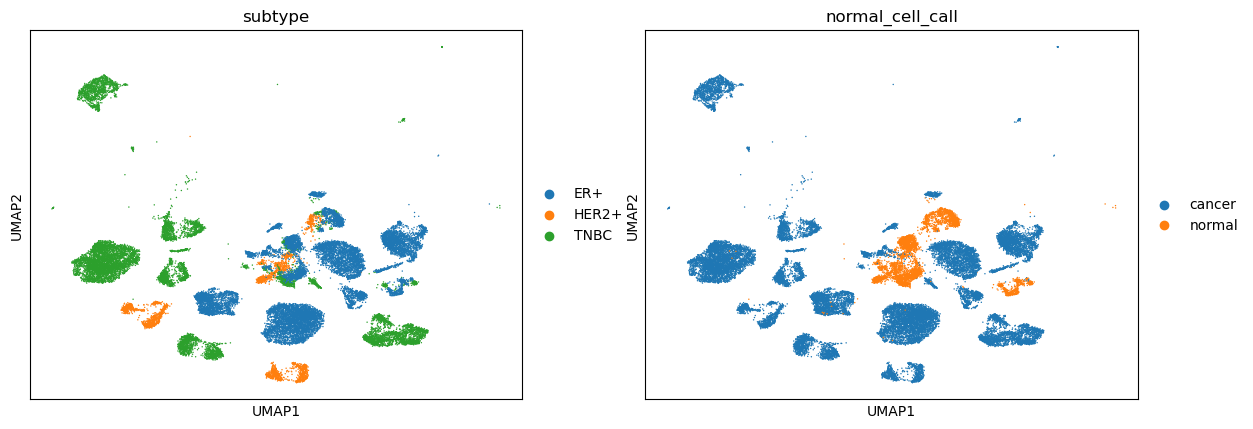

In [16]:
sc.pl.umap(adata_bc_epi, color=["subtype", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters

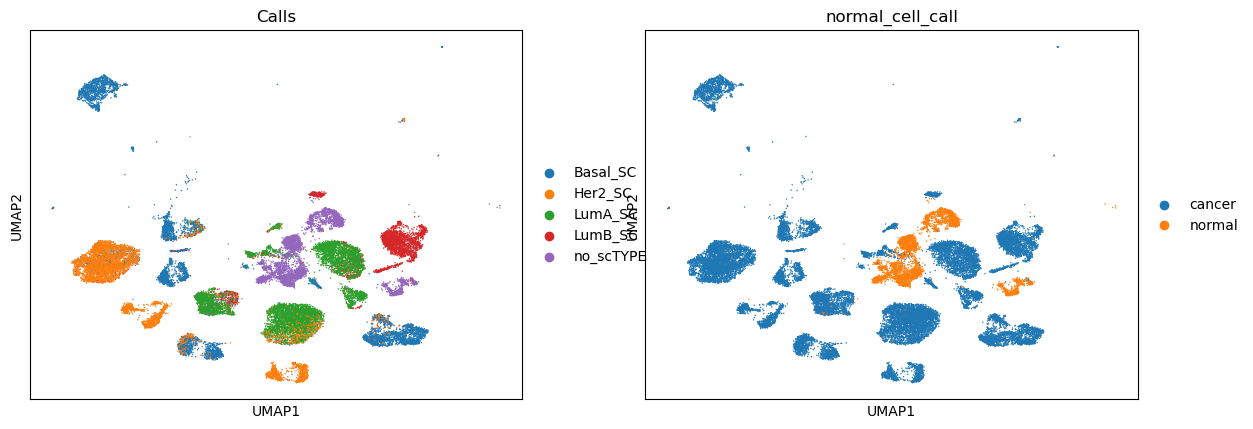

In [17]:
sc.pl.umap(adata_bc_epi, color=["Calls", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


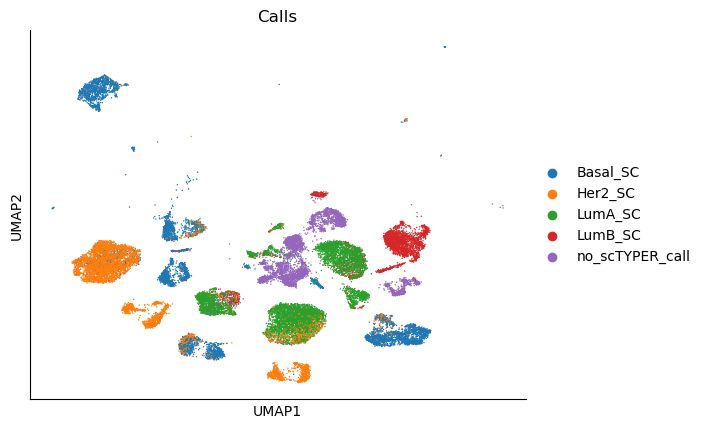

In [18]:
fig, ax = plt.subplots()

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

sc.pl.umap(adata_bc_epi, color="Calls", ax=ax)

In [19]:
adata_bc_epi.obs.Calls.value_counts()

Calls
LumA_SC            7943
Basal_SC           6631
Her2_SC            5711
no_scTYPER_call    4355
LumB_SC            4204
Name: count, dtype: int64

In [20]:
sc.tl.rank_genes_groups(adata_bc_epi, groupby='Calls', method='wilcoxon', use_raw=False, reference='no_scTYPER_call')

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromn

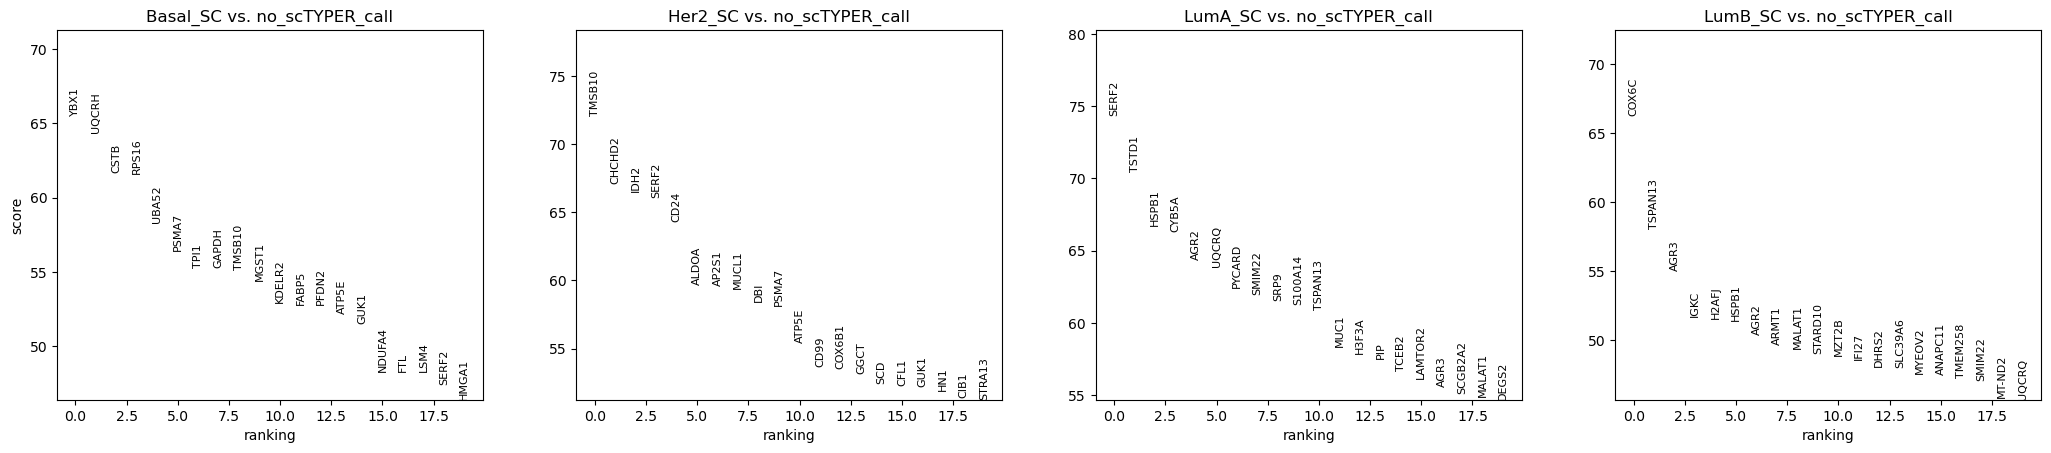

In [21]:
sc.pl.rank_genes_groups(adata_bc_epi, sharey=False)#, gene_symbols="feature_name")

In [22]:
lum_disreg_enrich = pd.DataFrame()
lum_omim_enrich = pd.DataFrame()
lum_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [23]:
de_genes = sc.get.rank_genes_groups_df(adata_bc_epi, group=None,  pval_cutoff=1e-2)
de_genes = de_genes[de_genes.group == "LumA_SC"]
de_genes.index = pd.MultiIndex.from_frame(de_genes[["names", "group"]])
de_genes

de_genes = de_genes["logfoldchanges"].unstack(level=1).T
de_genes.head()

de_genes = de_genes.loc[:, ~de_genes.T.LumA_SC.isna().T]

In [24]:
enr = gp.enrich(de_genes.loc[:, (de_genes.T.LumA_SC.abs() > 1).T].columns.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,Mammary Neoplasms,550/2387,1.841115e-42,1.580781e-38,0,0,2.159039,207.479726,SERPINE2;ENO1;F11R;RBPJ;CLDN1;ELK3;MYLK;EPS8;P...
1,DisGeNET,Neoplasm Metastasis,767/3920,3.385002e-33,1.453181e-29,0,0,1.785592,133.501474,TES;MAML2;SERPINE2;ZFYVE9;TMEM97;ENO1;ACCS;F11...
2,DisGeNET,Breast Carcinoma,922/4963,3.005220e-32,8.600939e-29,0,0,1.706899,123.890785,ZFYVE9;C4BPA;F11R;RBPJ;CLDN1;MYLK;PREX1;UBASH3...
3,DisGeNET,Tumor Progression,464/2090,3.756943e-31,8.064278e-28,0,0,2.005470,140.496293,CHIC2;ENO1;F11R;CLDN1;EPS8;PREX1;GJA1;ALCAM;MY...
4,DisGeNET,Malignant neoplasm of breast,926/5054,4.694110e-30,8.060726e-27,0,0,1.670937,112.840438,ZFYVE9;ACCS;F11R;RBPJ;CLDN1;MYLK;PREX1;UBASH3B...
...,...,...,...,...,...,...,...,...,...,...
8581,DisGeNET,Cortical visual impairment,1/46,9.987239e-01,9.991286e-01,0,0,0.142374,0.000182,CACNA1D
8582,DisGeNET,Dystonic disease,9/148,9.988023e-01,9.991286e-01,0,0,0.413800,0.000496,ARSA;ECM1;ARV1;NDUFS8;NDUFAF6;SPR;UQCRQ;EARS2;...
8583,DisGeNET,"Blindness, Cortical",1/47,9.988958e-01,9.991286e-01,0,0,0.139271,0.000154,CACNA1D
8584,DisGeNET,Central visual impairment,1/52,9.994641e-01,9.995805e-01,0,0,0.125580,0.000067,CACNA1D


In [25]:
dc.check_corr(mcf7, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
4751,E4F1,EP300,-0.0703
5015,HDGF,KMT2A,-0.0622
5273,E2F4,NR2F2,-0.0545
5328,ARID1B,HDAC1,-0.0531
5412,KMT2A,ZBTB33,-0.0506
...,...,...,...
4,PML,TAF1,0.5365
3,MAX,ZNF143,0.5384
2,MAX,MYC,0.5417
1,MED1,ZNF143,0.5529


In [26]:
dc.check_corr(collectri, mat=de_genes).sort_values("corr")

,source1,source2,corr
5,E4F1,SMARCA4,-0.3104
13,MTA1,MTA3,-0.2522
20,MAX,MNT,-0.2277
26,MBD2,ZBTB33,-0.2064
33,CUX1,ELF1,-0.1857
...,...,...,...
4,HDGF,TEAD4,0.3320
3,ARID1A,SMARCA4,0.3329
2,SMARCA4,ZBTB33,0.3331
1,FOS,JUN,0.3665


CollecTri

In [27]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri)

In [28]:
mask_ctri = tf_pvals_ctri < 0.05

active_tfs_ctri = tf_acts_ctri.loc[:, pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].columns.to_list()

In [29]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/bc_lum_activity_collectri.tsv", sep="\t", index=False)

In [30]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_collectri_lum.tsv", sep="\t", index=False)
lum_omim_enrich = pd.concat([lum_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [31]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_collectri_lum.tsv", sep="\t", index=False)
enr.results["Network"] = "CollecTri"
lum_disreg_enrich = pd.concat([lum_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [32]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_collectri_lum.tsv", sep="\t", index=False)
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, pd.DataFrame()], axis=0)

In [33]:
heat = pd.concat([tf_acts_ctri.rename({"LumA_SC": "score"}), tf_pvals_ctri.rename({"LumA_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-2.540153,1.110320e-02,CollecTri
AR,-1.115716,2.645847e-01,CollecTri
ARID1A,-0.167146,8.672601e-01,CollecTri
ARNT,-0.689957,4.902455e-01,CollecTri
BRD4,-0.220824,8.252362e-01,CollecTri
...,...,...,...
TP53,-5.690541,1.320917e-08,CollecTri
TRPS1,-0.537151,5.911816e-01,CollecTri
ZBTB33,2.192834,2.835426e-02,CollecTri
ZBTB7B,-0.709299,4.781642e-01,CollecTri


MCF7

In [34]:
tf_acts_mcf7, tf_pvals_mcf7 = dc.run_ulm(de_genes, mcf7, source='tf', target='gene_symbol', weight=None)

In [35]:
mask_mcf7 = tf_pvals_mcf7 < 0.05

active_tfs_mcf7 = tf_acts_mcf7.loc[:, pd.DataFrame(tf_acts_mcf7 * mask_mcf7).sum(axis=0) != 0].columns.to_list()

In [36]:
tf_acts_mcf7.index = ["score"]
tf_pvals_mcf7.index = ["p_value"]
out_mcf7 = pd.merge(left=tf_acts_mcf7.T, right=tf_pvals_mcf7.T, left_index=True, right_index=True)
out_mcf7.to_csv("../data/3-tf_activity/bc_lum_activity_m2kb.tsv", sep="\t", index=False)

In [37]:
enr = gp.enrich(active_tfs_mcf7, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_m2kb_mcf7_lum.tsv", sep="\t", index=False)
lum_omim_enrich = pd.concat([lum_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [38]:
enr = gp.enrich(active_tfs_mcf7, "DisGeNET")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_m2kb_mcf7_lum.tsv", sep="\t", index=False)
lum_disreg_enrich = pd.concat([lum_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [39]:
try:
    enr = gp.enrich(gene_list=active_tfs_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_m2kb_mcf7_lum.tsv", sep="\t", index=False)
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_MCF-7"
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, pd.DataFrame()], axis=0)

In [40]:
heat = pd.concat([tf_acts_mcf7.rename({"LumA_SC": "score"}), tf_pvals_mcf7.rename({"LumA_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_MCF-7"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-2.540153,1.110320e-02,CollecTri
AR,-1.115716,2.645847e-01,CollecTri
ARID1A,-0.167146,8.672601e-01,CollecTri
ARNT,-0.689957,4.902455e-01,CollecTri
BRD4,-0.220824,8.252362e-01,CollecTri
...,...,...,...
ZNF217,10.317623,9.055865e-25,M2Kb_MCF-7
ZNF24,5.327606,1.028203e-07,M2Kb_MCF-7
ZNF444,9.968631,3.055077e-23,M2Kb_MCF-7
ZNF512B,3.484271,4.966960e-04,M2Kb_MCF-7


chip_atlas_mcf7

In [41]:
tf_acts_chip_atlas_mcf7, tf_pvals_chip_atlas_mcf7 = dc.run_ulm(de_genes, chip_atlas_mcf7.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals_chip_atlas_mcf7.loc["LumA_SC"] = fdrcorrection(tf_pvals_chip_atlas_mcf7.T["LumA_SC"])[1]

In [42]:
mask_chip_atlas_mcf7 = tf_pvals_chip_atlas_mcf7 < 0.05

active_tfs_chip_atlas_mcf7 = tf_acts_chip_atlas_mcf7.loc["LumA_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0].index.to_list()
tf_acts_chip_atlas_mcf7.loc["LumA_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0]

AHR        3.883107
AR         3.921206
ARID1A     6.715631
ARID1B     5.616512
ARNT       7.879448
            ...    
ZHX2       6.018441
ZNF143    12.175611
ZNF217     9.998899
ZNF24      2.464850
ZNF444     7.473907
Name: LumA_SC, Length: 100, dtype: float32

In [43]:
tf_acts_chip_atlas_mcf7.index = ["score"]
tf_pvals_chip_atlas_mcf7.index = ["p_value"]
out_chip_atlas_mcf7 = pd.merge(left=tf_acts_chip_atlas_mcf7.T, right=tf_pvals_chip_atlas_mcf7.T, left_index=True, right_index=True)
out_chip_atlas_mcf7.to_csv("../data/3-tf_activity/bc_lum_activity_ca_mcf7.tsv", sep="\t", index=False)

In [44]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "OMIM_Expanded")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_ca_mcf7_lum.tsv", sep="\t", index=False)
    lum_omim_enrich = pd.concat([lum_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    lum_omim_enrich = pd.concat([lum_omim_enrich, pd.DataFrame()], axis=0)

In [45]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "DisGeNET")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_ca_mcf7_lum.tsv", sep="\t", index=False)
    lum_disreg_enrich = pd.concat([lum_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    lum_disreg_enrich = pd.concat([lum_disreg_enrich, pd.DataFrame()], axis=0)

In [46]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_ca_mcf7_lum.tsv", sep="\t", index=False)
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_MCF-7"
    lum_cosmic_enrich = pd.concat([lum_cosmic_enrich, pd.DataFrame()], axis=0)

In [47]:
heat = pd.concat([tf_acts_chip_atlas_mcf7.rename({"LumA_SC": "score"}), tf_pvals_chip_atlas_mcf7.rename({"LumA_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("LumA_SC", ascending=False).index).head(5)
heat["Network"] = "CA_MCF-7"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-2.540153,1.110320e-02,CollecTri
AR,-1.115716,2.645847e-01,CollecTri
ARID1A,-0.167146,8.672601e-01,CollecTri
ARNT,-0.689957,4.902455e-01,CollecTri
BRD4,-0.220824,8.252362e-01,CollecTri
...,...,...,...
ZNF217,9.998899,2.261896e-23,CA_MCF-7
ZNF24,2.464850,1.373242e-02,CA_MCF-7
ZNF444,7.473907,8.796393e-14,CA_MCF-7
ZNF512B,0.087174,9.305355e-01,CA_MCF-7


Plotting results

In [48]:
okabe = [pal[0], pal[7], pal[3]]

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_omim_lum.svg


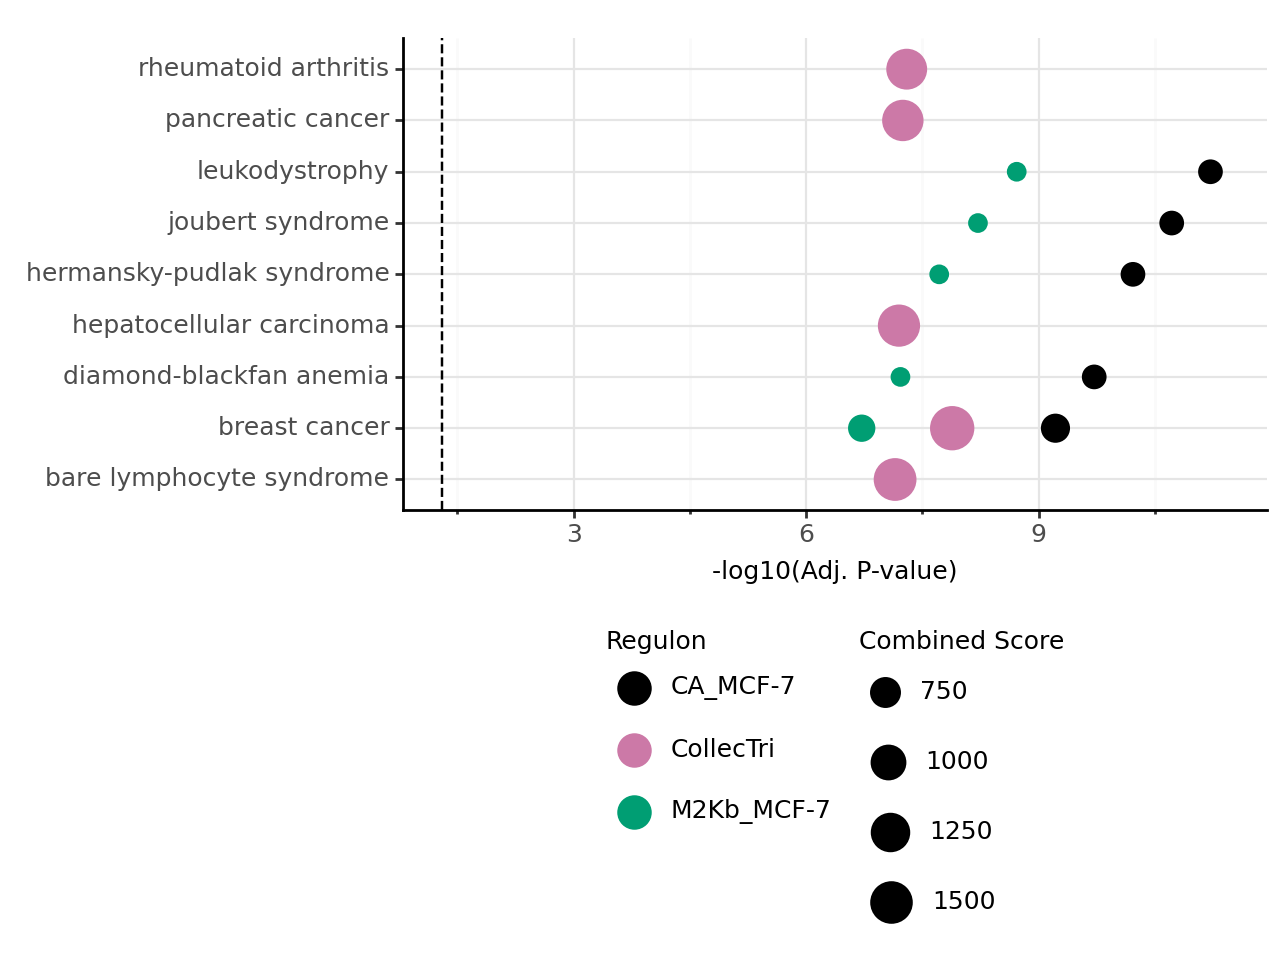

<Figure Size: (640 x 480)>

In [49]:
lum_omim_enrich["-log10(Adj. P-value)"] = - np.log10(lum_omim_enrich["Adjusted P-value"])
lum_omim_enrich = lum_omim_enrich.loc[lum_omim_enrich["Adjusted P-value"] < 0.05]
lum_omim_enrich.describe()

p = plot_enrich(lum_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_omim_lum.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_lum.svg


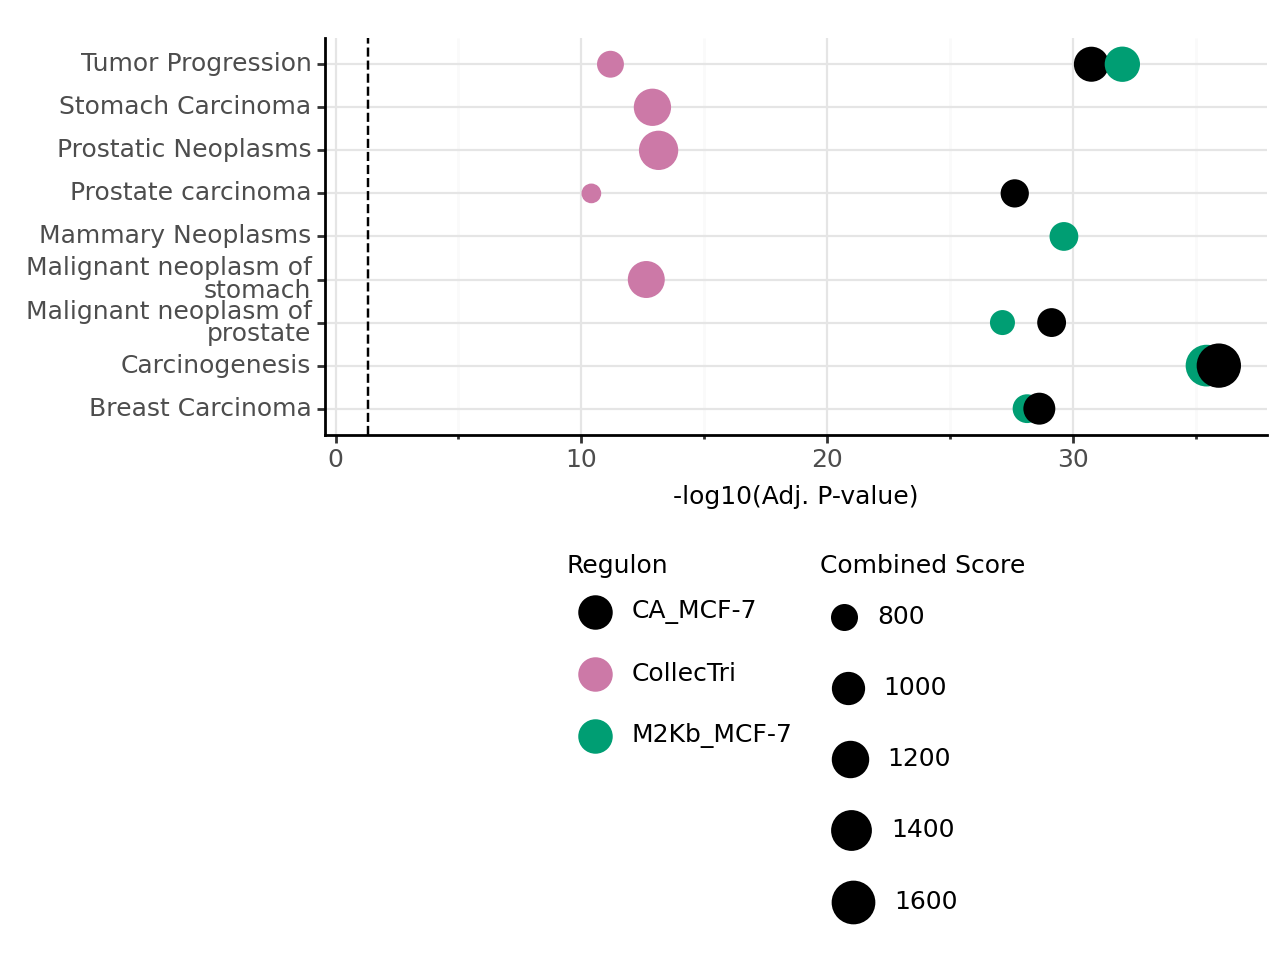

<Figure Size: (640 x 480)>

In [50]:
lum_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(lum_disreg_enrich["Adjusted P-value"])
lum_disreg_enrich = lum_disreg_enrich.loc[lum_disreg_enrich["Adjusted P-value"] < 0.05]
lum_disreg_enrich.describe()

p = plot_enrich(lum_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_lum.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_lum.svg


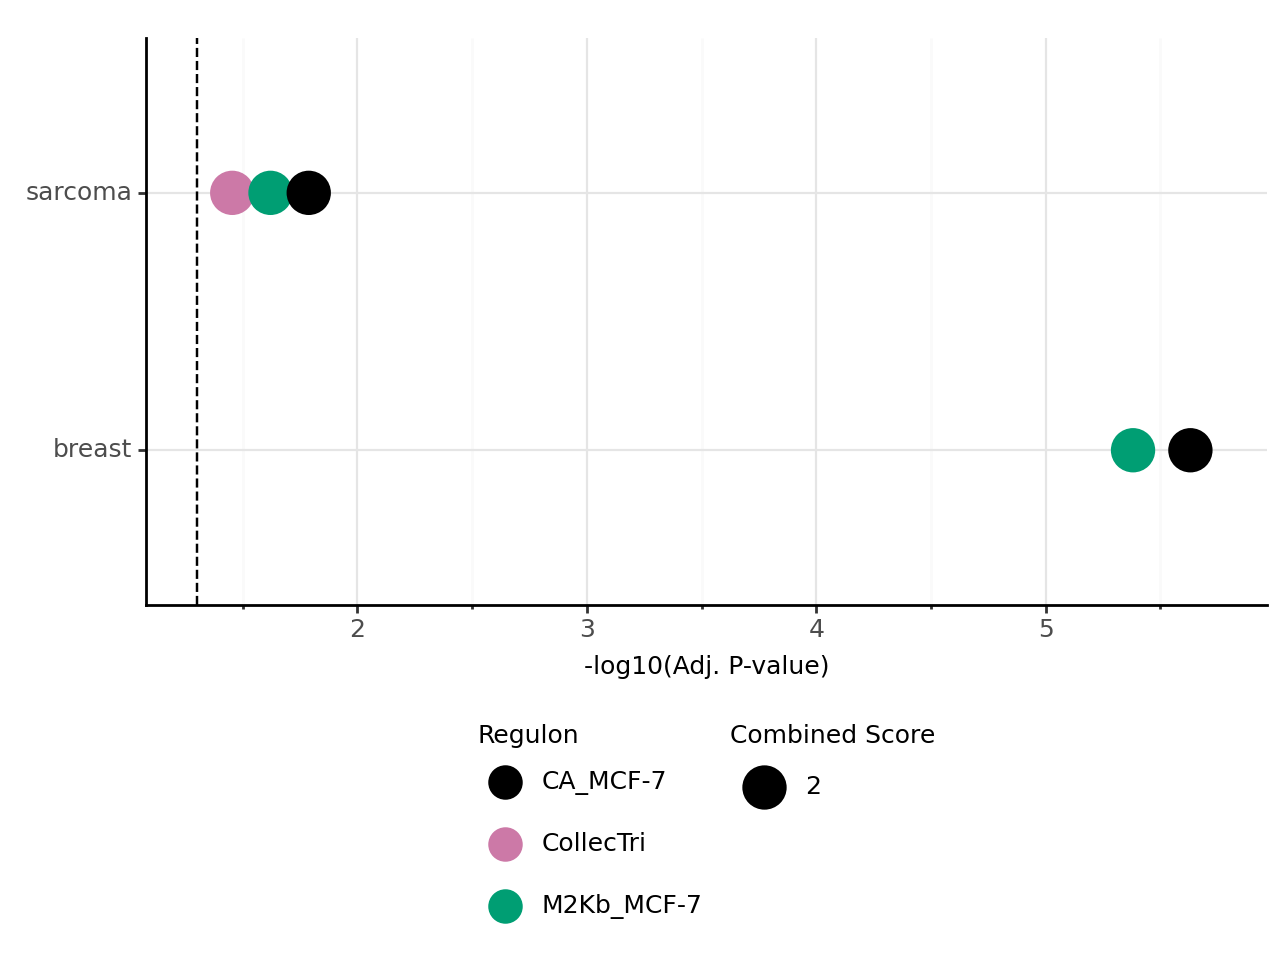

<Figure Size: (640 x 480)>

In [51]:
lum_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(lum_cosmic_enrich["Adjusted P-value"])
lum_cosmic_enrich = lum_cosmic_enrich.loc[lum_cosmic_enrich["Adjusted P-value"] < 0.05]
lum_cosmic_enrich.describe()

p = plot_enrich(lum_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_lum.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [52]:
megaheat.to_csv("../data/3-tf_activity/bc_activity_estimates_lum.tsv", sep="\t", index=False)

In [53]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(0)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [54]:
megaheat.sort_values("score")

,score,p_value,Network,TF,log_p
RELA,-5.998646,2.095374e-09,CollecTri,RELA,9.0
TP53,-5.690541,1.320917e-08,CollecTri,TP53,8.0
JUN,-5.599925,2.231118e-08,CollecTri,JUN,8.0
SRF,-5.523906,3.442412e-08,CollecTri,SRF,7.0
CEBPB,-5.155452,2.604062e-07,CollecTri,CEBPB,7.0
...,...,...,...,...,...
ELF1,13.743076,2.151186e-42,CA_MCF-7,ELF1,42.0
BRD4,14.065759,2.692160e-44,CA_MCF-7,BRD4,44.0
PML,14.257852,1.896562e-45,CA_MCF-7,PML,45.0
SIN3A,14.748959,1.846774e-48,CA_MCF-7,SIN3A,48.0


In [55]:
print(megaheat[megaheat.Network == "M2Kb_MCF-7"].sort_values("score").to_string())

             score       p_value     Network       TF  log_p
MTA2      1.985589  4.712045e-02  M2Kb_MCF-7     MTA2    1.0
NR5A2     2.071805  3.832257e-02  M2Kb_MCF-7    NR5A2    1.0
JUNB      2.123985  3.370860e-02  M2Kb_MCF-7     JUNB    1.0
TLE3      2.189320  2.860862e-02  M2Kb_MCF-7     TLE3    2.0
ARID3A    2.288548  2.213719e-02  M2Kb_MCF-7   ARID3A    2.0
CTBP2     2.423409  1.540240e-02  M2Kb_MCF-7    CTBP2    2.0
OVOL1     2.480325  1.315111e-02  M2Kb_MCF-7    OVOL1    2.0
NONO      2.513587  1.197472e-02  M2Kb_MCF-7     NONO    2.0
SP1       2.664960  7.718546e-03  M2Kb_MCF-7      SP1    2.0
HDGF      2.732567  6.301085e-03  M2Kb_MCF-7     HDGF    2.0
MTA3      2.970718  2.981787e-03  M2Kb_MCF-7     MTA3    3.0
HES1      2.989895  2.801070e-03  M2Kb_MCF-7     HES1    3.0
ZBTB33    3.219478  1.290482e-03  M2Kb_MCF-7   ZBTB33    3.0
E2F4      3.437601  5.905303e-04  M2Kb_MCF-7     E2F4    3.0
E4F1      3.470023  5.237541e-04  M2Kb_MCF-7     E4F1    3.0
ZNF512B   3.484271  4.96

/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


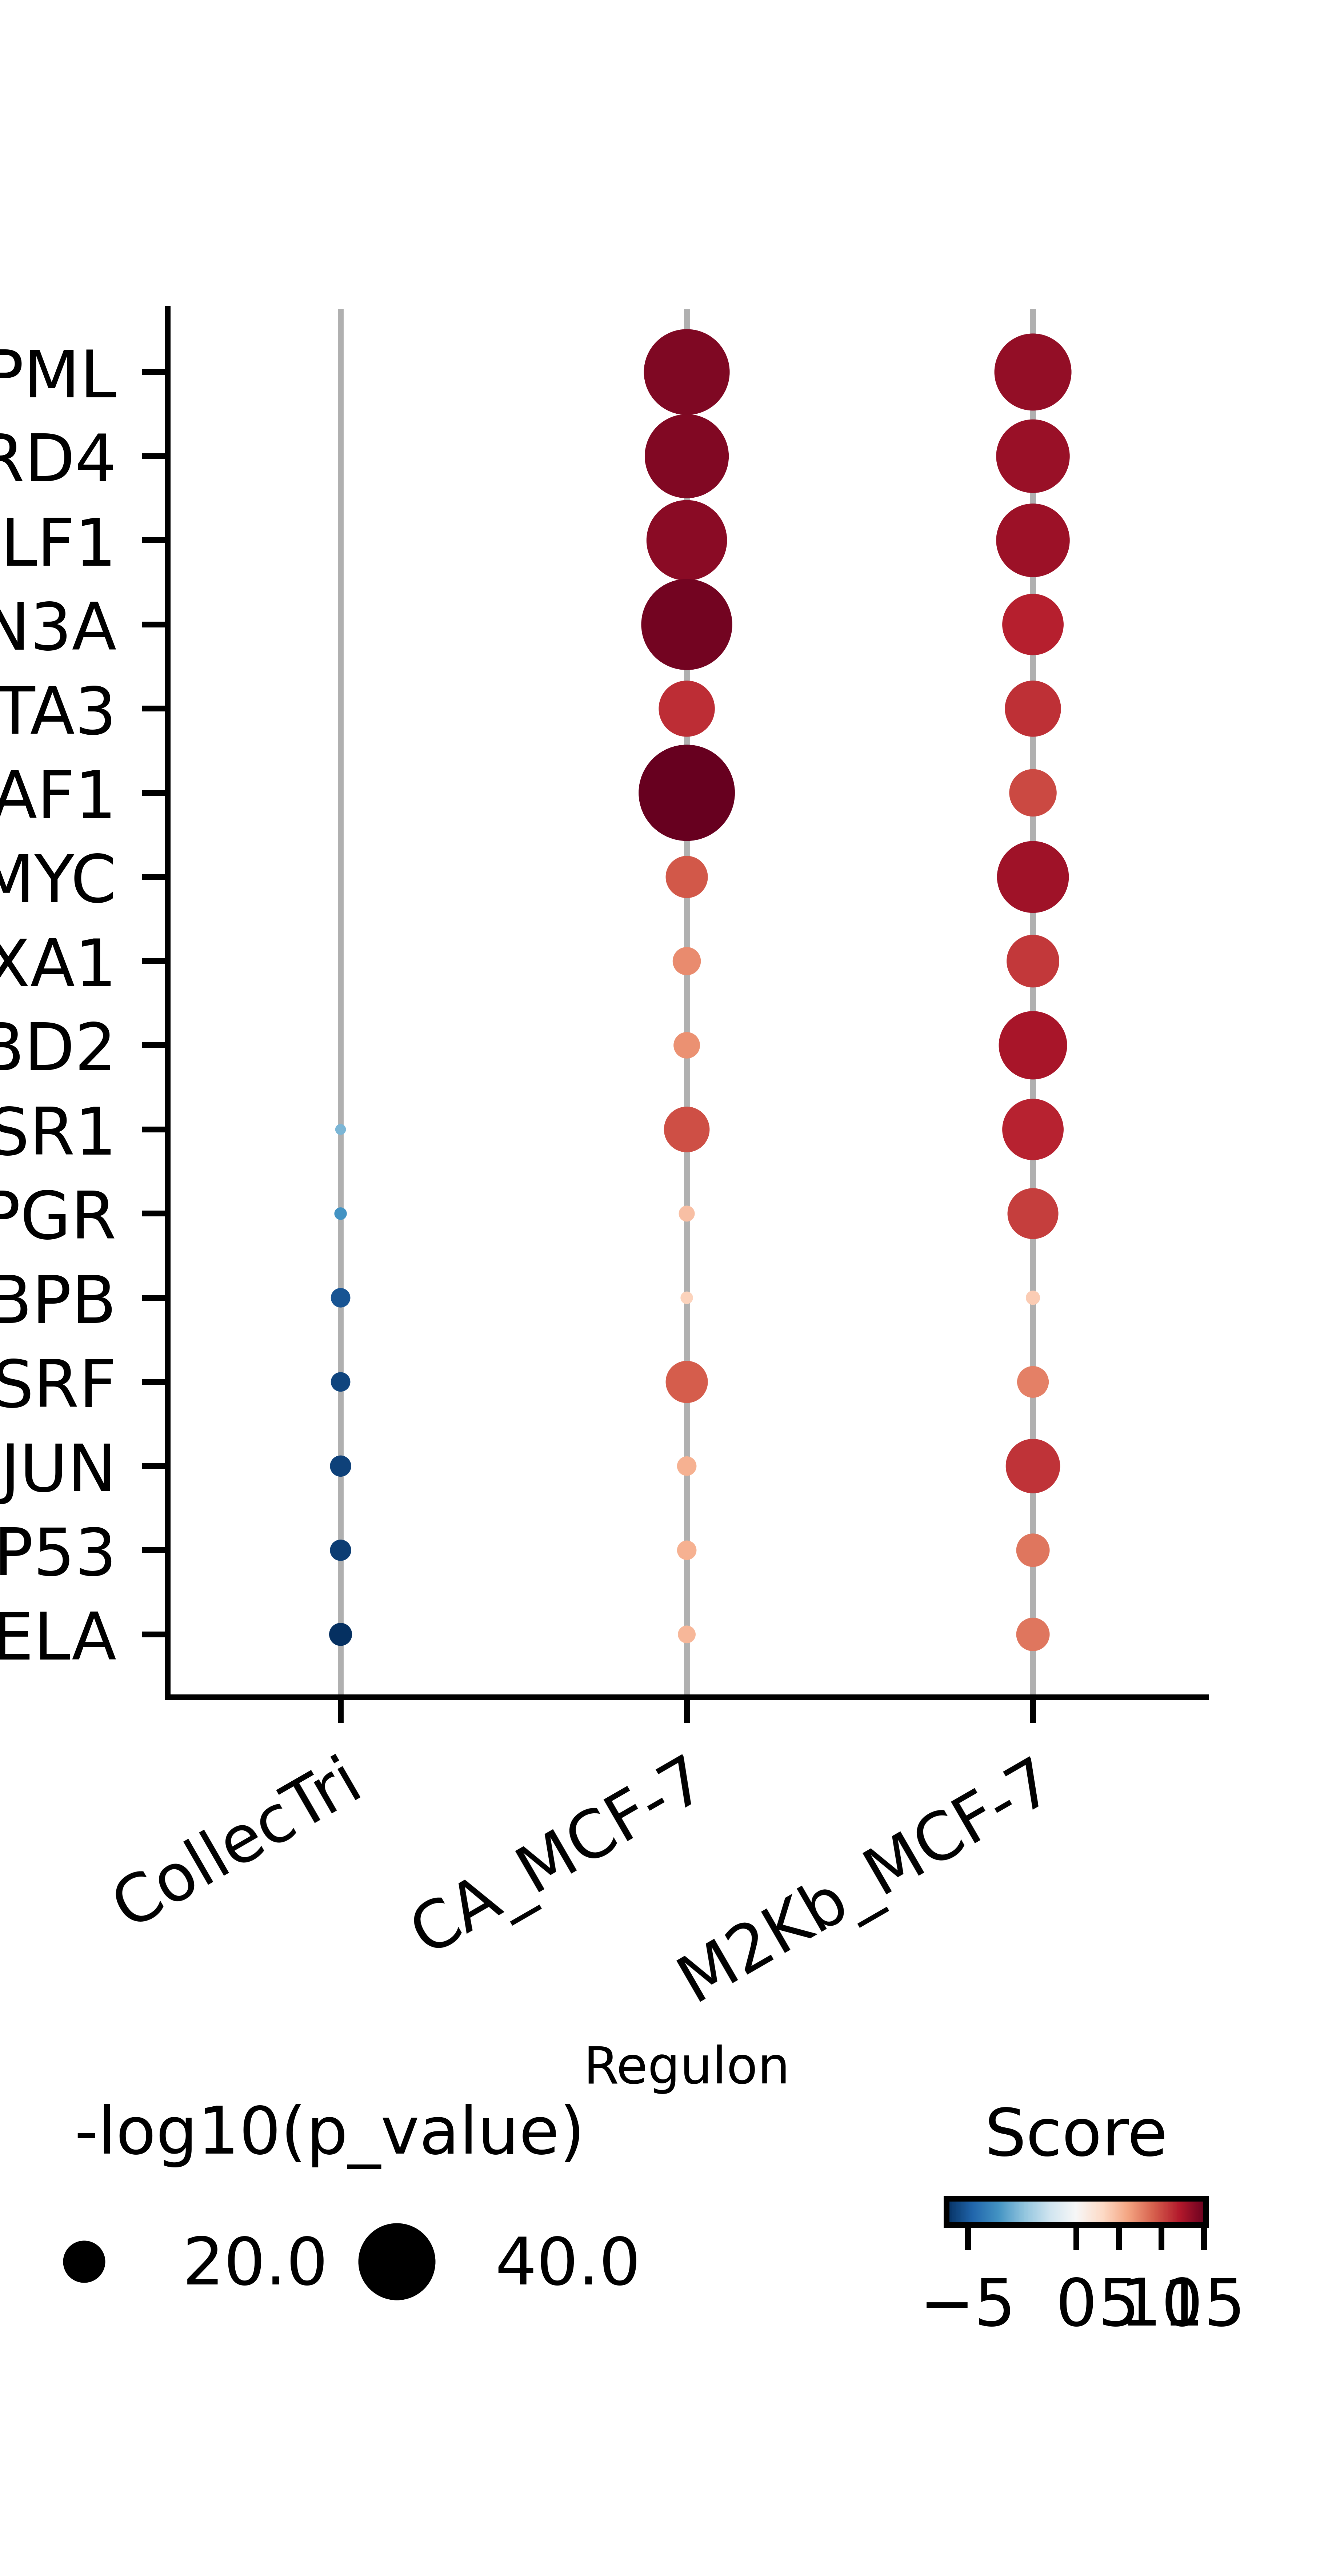

In [56]:
out = pd.DataFrame()
interesting_tf = ["ESR1", "PGR", "GATA3", "FOXA1"]
#interesting_tf = []
for net in ["CollecTri", "M2Kb_MCF-7", "CA_MCF-7"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
out = out.drop_duplicates(["TF", "score"])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_MCF-7", "CA_MCF-7"])], scale=0.04)
plt.savefig("../plots/3-tf_activity/bc_activity_clustermap_lum.svg", dpi=720, format="svg")

In [57]:
out

,score,p_value,Network,TF,log_p
RELA,-5.998646,2.095374e-09,CollecTri,RELA,9.0
TP53,-5.690541,1.320917e-08,CollecTri,TP53,8.0
JUN,-5.599925,2.231118e-08,CollecTri,JUN,8.0
SRF,-5.523906,3.442412e-08,CollecTri,SRF,7.0
CEBPB,-5.155452,2.604062e-07,CollecTri,CEBPB,7.0
PGR,-3.569362,3.604047e-04,CollecTri,PGR,3.0
ESR1,-2.733860,6.276416e-03,CollecTri,ESR1,2.0
CEBPB,3.476530,5.112312e-04,CA_MCF-7,CEBPB,3.0
CEBPB,3.927040,8.687718e-05,M2Kb_MCF-7,CEBPB,4.0
PGR,4.563396,5.124737e-06,CA_MCF-7,PGR,5.0
